In [6]:
import pandas as pd
import optuna
import numpy as np
import logging
import copy
import os
import timeout_decorator

from IPython.display import display

import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

from lightgbm import LGBMClassifier

from scipy.stats import ttest_ind

from sklearn import linear_model
from sklearn.svm import SVC

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

from sklearn.preprocessing import StandardScaler

from pathlib import Path

Path(os.getcwd()).parents[2]

import sys

sys.path.append(Path(os.getcwd()).parents[2].as_posix())

from lib.validation import get_elasticnet_model, get_svm_linear_model, get_svm_rbf_model

logger = logging.getLogger()

optuna.logging.set_verbosity(optuna.logging.ERROR)

os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"

In [7]:
# Set random seed so this part is reproducible
# https://www.random.org/ 2023-08-09
np.random.seed(3866)

In [8]:
def roll_genes(genes):
    mgenes = np.empty((genes.shape[0], genes.shape[0]), dtype=object)
    for i in range(genes.shape[0]):
        for j, (g1, g2) in enumerate(zip(genes, np.roll(genes, i))):
            mgenes[j, i] = f"{g2}:{g1}"
    return mgenes
    
def divs(array):
    matrix = np.zeros((array.shape[0], array.shape[0]))
    for i in range(array.shape[0]):
        matrix[:, i] = np.roll(array, i)
    return matrix

def col_div(col):
    denominator = col
    numerator = divs(denominator)
    diffs = numerator / denominator[:, np.newaxis]
    return diffs.flatten()

def fast(mat):
    
    mgenes = roll_genes(np.arange(len(mat)))
    
    matrix = pd.DataFrame(index=mgenes.flatten(), 
                          columns=range(mat.shape[1]))
    
    for i in range(mat.shape[1]):
        matrix.loc[:, i] = col_div(mat[i].values)
            
    return matrix


def calculate_ratios(log2tpm1):
    
    from sklearn import preprocessing

    tpm = (2**log2tpm1) - 1.0

    scaler = preprocessing.MinMaxScaler(feature_range=(1, 100))
    norm = pd.DataFrame(index=tpm.index, columns=log2tpm1.columns)

    gene_bounds = pd.DataFrame(index=tpm.index, columns=['q1', 'q2', 'q3', 'upper_outlier', 'lower_outlier'])

    for gene in norm.index.values:

        try:

            vec = tpm.loc[gene, :].values.reshape(-1, 1)
            q1 = np.percentile(vec, 25)
            q2 = np.percentile(vec, 50)
            q3 = np.percentile(vec, 75)

            upper_outlier = q3 + 1.5 * (q3 - q1)
            lower_outlier = q1 - 1.5 * (q3 - q1)

            gene_bounds.loc[gene, :] = [q1, q2, q3, upper_outlier, lower_outlier]

            idx, _ = np.where(vec > upper_outlier)
            vec[idx] = upper_outlier

            idx, _ = np.where(vec < lower_outlier)
            vec[idx] = lower_outlier

            norm.loc[gene, :] = scaler.fit_transform(vec).flatten()

        except Exception as e:
            print(e)
            
    ratio = fast(pd.DataFrame(norm.values))
    ratio = ratio.astype(np.float64)
    ratio.columns = tpm.columns
    return ratio, norm

In [9]:
def run_analysis(e, n, f, c):
    #
    # Train
    #
    train_minmax_path = f"../../../data/test/test_input/2024-01-09/synthetic-train-minmax-eff-{e}-ndiff-{n}-frac-{f}-corr-{c}-2024-01-09.tsv"
    
    assert os.path.exists(train_minmax_path)
    
    train_minmax = pd.read_csv(train_minmax_path,
                     sep='\t', 
                     index_col=0)

    train_minmax = train_minmax.sample(frac=1.0, axis=1)
    
    ratio_path = f"../../../data/test/test_input/2024-01-09/synthetic-train-minmax-ratios-eff-{e}-ndiff-{n}-frac-{f}-corr-{c}-splits-1-2024-01-09.tsv"
    
    assert os.path.exists(ratio_path)
    
    trainR = pd.read_csv(ratio_path,
                         sep='\t', 
                         header=None,
                         comment="#")
    
    trainR.columns = ["numerator", "denominator", "score"]
    
    trainR["ratio"] = trainR["numerator"] + ":::" + trainR["denominator"]
    
    top_ratios = trainR.sort_values("score", ascending=False).head(500)
    
    trainX = pd.DataFrame(index=top_ratios["ratio"], columns=train_minmax.columns, dtype=np.float64)
    
    for i, row in top_ratios.iterrows():
        trainX.loc[row.ratio] = train_minmax.loc[row["numerator"], :] / train_minmax.loc[row["denominator"], :]
        
    trainY = np.array([0 if x.startswith("nonresponders") else 1 for x in trainX.columns])
    
    #
    # Test
    #
    test_minmax_path = f"../../../data/test/test_input/2024-01-09/synthetic-test-minmax-eff-{e}-ndiff-{n}-frac-{f}-corr-{c}-2024-01-09.tsv"
    
    assert os.path.exists(test_minmax_path)
    
    test_minmax = pd.read_csv(test_minmax_path,
                        sep='\t', 
                        index_col=0)

    test_minmax = test_minmax.sample(frac=1.0, axis=1)
    
    testX = pd.DataFrame(index=top_ratios["ratio"], columns=test_minmax.columns, dtype=np.float64)
    
    for i, row in top_ratios.iterrows():
        testX.loc[row.ratio] = test_minmax.loc[row["numerator"], :] / test_minmax.loc[row["denominator"], :]
        
    testY = np.array([0 if x.startswith("nonresponders") else 1 for x in testX.columns])
    
    # Elastic Net
    elastic_net_model, elastic_net_model_best_value, elastic_net_model_params = get_elasticnet_model(trainX.values.T, trainY, n_trials=100)
    
    # RBF SVM Model
    rbf_svm_model, rbf_svm_model_best_value, rbf_svm_params = get_svm_rbf_model(trainX.values.T, trainY, n_trials=100)
    
    # Linear SVM Model 
    linear_svm_model, linear_svm_model_best_value, linear_svm_params = get_svm_linear_model(trainX.values.T, trainY, n_trials=100)
    
    #
    # ROC
    #
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].plot(np.linspace(0, 1.0, 10), np.linspace(0.0, 1.0, 10), linestyle='--', color="gray")
    axes[1].plot(np.linspace(0, 1.0, 10), np.linspace(0.0, 1.0, 10), linestyle='--', color="gray")

    
    stats = []
    
    for name, model, params in [("ElasticNet", elastic_net_model, elastic_net_model_params), ("Linear SVM", linear_svm_model, linear_svm_params), ("RBF SVM", rbf_svm_model, rbf_svm_params)]:
        
        X_train = trainX.values.T
        features = params["features"]
        _X_train = X_train[:, :features]
        np.take(_X_train, np.random.rand(_X_train.shape[1]).argsort(), axis=1, out=_X_train)

        RocCurveDisplay.from_estimator(model, 
                                       _X_train, 
                                       trainY, 
                                       name=name,
                                       ax=axes[0])
        
        train_auc = roc_auc_score(trainY, model.predict_proba(_X_train)[:, 1])
        stats.append((name, "train", e, n, f, c, train_auc, train_minmax_path))

        X_test = testX.values.T
        features = params["features"]
        _X_test = X_test[:, :features]
        np.take(_X_test, np.random.rand(_X_test.shape[1]).argsort(), axis=1, out=_X_test)

        RocCurveDisplay.from_estimator(model, 
                                       _X_test, 
                                       testY, 
                                       name=name,
                                       ax=axes[1])
                                  
        test_auc = roc_auc_score(testY, model.predict_proba(_X_test)[:, 1])
        stats.append((name, "test", e, n, f, c, test_auc, test_minmax_path))
        
    axes[0].set_title(f"ROC Curve for Synthetic Training Data\nES: {e} DEGs: {n} Response%: {f} Corr Thresh: {c}")
    axes[1].set_title(f"ROC Curve for Synthetic Testing Data\nES: {e} DEGs: {n} Response%: {f} Corr Thresh: {c}")

    plt.tight_layout()

    plt.savefig(f"../../../figures/synthetic/synthetic-top-ratios-prediction-roc-curve-plots-eff-{e}-ndiff-{n}-frac-{f}-corr-{c}.svg", 
                format='svg', 
                bbox_inches='tight')
    
    return pd.DataFrame(stats, 
                        columns=["model", "dataset", "effect", "ndeg", "subtype_frac", "corr_thresh", "AUC", "path"])

In [10]:
# Generate ratios for validation

ratios = ['77:899',
          '303:917',
          '334:917',
          '82:215',
          '77:314',
          '148:917',
          '113:191',
          '23:314',
          '35:314',
          '103:248']


tmp = pd.read_csv("../../../data/test/test_input/2023-08-14/synthetic-train-eff-0.5-ndiff-10-frac-0.1-2023-08-14.tsv",
                     sep='\t', 
                     index_col=0)

numerators = []
denominators = []
for r in ratios:
    n, d = r.split(":")
    
    ng = tmp.index.values[int(n)]
    if ng not in numerators:
        numerators.append(ng)
    
    dg = tmp.index.values[int(d)]
    if dg not in denominators:
        denominators.append(dg)

In [11]:
#
# Train
#
trainX = pd.read_csv("../../../data/test/test_input/2023-08-14/synthetic-train-eff-0.5-ndiff-10-frac-0.1-2023-08-14.tsv",
                     sep='\t', 
                     index_col=0)

trainX = trainX.sample(frac=1.0, axis=1)

trainR, trainN = calculate_ratios(trainX)

trainN.to_csv("../../../data/test/test_input/2023-08-14/synthetic-train-minmax-eff-0.5-ndiff-10-frac-0.1-2023-08-14.tsv", sep='\t')

trainX = trainR.reindex(ratios)

trainY = np.array([0 if x.startswith("nonresponders") else 1 for x in trainX.columns])


#
# Test
#
testX = pd.read_csv("../../../data/test/test_input/2023-08-14/synthetic-test-eff-0.5-ndiff-10-frac-0.1-2023-08-14.tsv",
                    sep='\t', 
                    index_col=0)

testX = testX.sample(frac=1.0, axis=1)

testR, testN = calculate_ratios(testX)

testN.to_csv("../../../data/test/test_input/2023-08-14/synthetic-test-minmax-eff-0.5-ndiff-10-frac-0.1-2023-08-14.tsv", sep='\t')

testX = testR.reindex(ratios)

testY = np.array([0 if x.startswith("nonresponders") else 1 for x in testX.columns])

# Elastic Net

In [12]:
# Elastic Net
elastic_net_model, elastic_net_model_features, elastic_net_model_best_value, elastic_net_model_params = get_elasticnet_model(trainX.values.T, trainY, n_trials=100)

In [13]:
# Elastic Net Best Value
elastic_net_model_best_value

0.923076923076923

In [14]:
# Elastic Net Of of Sample Prediction
X_test = testX.values.T
_X_test = X_test[:, elastic_net_model_features]

elastic_net_test_yhat = elastic_net_model.predict(_X_test)
f1_score(testY, elastic_net_test_yhat)

0.8571428571428571

# RBF SVM

In [15]:
rbf_svm_model, rbf_svm_model_features, rbf_svm_model_best_value, rbf_svm_model_params = get_svm_rbf_model(trainX.values.T, trainY, n_trials=100)

Stopping study because perfect score is reached


In [16]:
rbf_svm_model_best_value

1.0

In [17]:
# Elastic Net Of of Sample Prediction
X_test = testX.values.T
_X_test = X_test[:, rbf_svm_model_features]

rbf_svm_test_yhat = rbf_svm_model.predict(_X_test)
f1_score(testY, rbf_svm_test_yhat)

0.9230769230769231

# Linear SVM

In [18]:
linear_svm_model, linear_svm_model_features, linear_svm_model_best_value, linear_svm_model_params = get_svm_linear_model(trainX.values.T, trainY, n_trials=100)

In [19]:
linear_svm_model_best_value

0.9090909090909091

In [20]:
# Elastic Net Of of Sample Prediction
X_test = testX.values.T
_X_test = X_test[:, linear_svm_model_features]

linear_svm_test_yhat = linear_svm_model.predict(_X_test)
f1_score(testY, linear_svm_test_yhat)

0.9230769230769231

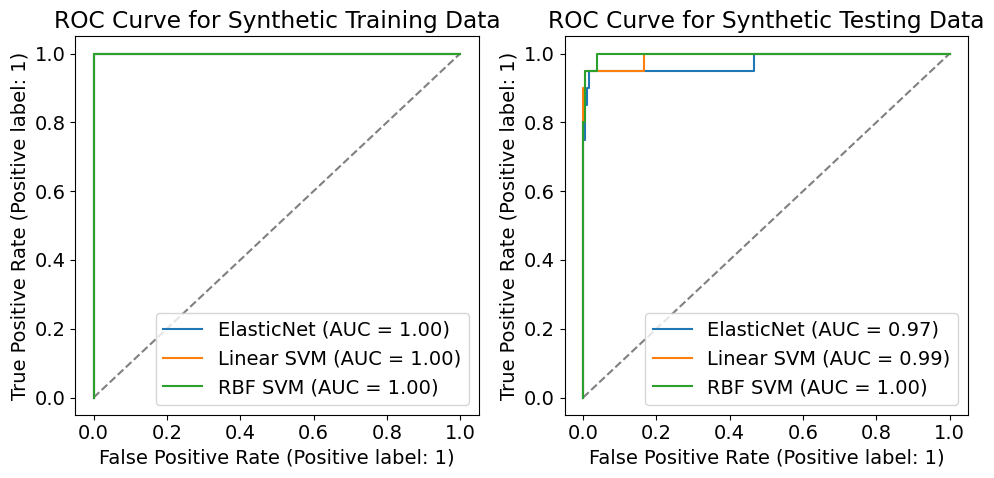

In [22]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(np.linspace(0, 1.0, 10), np.linspace(0.0, 1.0, 10), linestyle='--', color="gray")
axes[1].plot(np.linspace(0, 1.0, 10), np.linspace(0.0, 1.0, 10), linestyle='--', color="gray")

for name, model, _features in [("ElasticNet", elastic_net_model, elastic_net_model_features), 
                              ("Linear SVM", linear_svm_model, linear_svm_model_features), 
                              ("RBF SVM", rbf_svm_model, rbf_svm_model_features)]:
    
    X_train = trainX.values.T
    _X_train = X_train[:, _features]

    RocCurveDisplay.from_estimator(model, 
                                   _X_train, 
                                   trainY, 
                                   name=name,
                                   ax=axes[0])
    
    X_test = testX.values.T
    _X_test = X_test[:, _features]

    RocCurveDisplay.from_estimator(model, 
                                   _X_test, 
                                   testY, 
                                   name=name,
                                   ax=axes[1])

axes[0].set_title("ROC Curve for Synthetic Training Data")
axes[1].set_title("ROC Curve for Synthetic Testing Data")

plt.tight_layout()

plt.savefig("../../../figures/synthetic/synthetic-ratio-ml-prediction-roc-curve-plots.svg", 
            format='svg', 
            bbox_inches='tight')